In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from vgg import VGG
from utils import to_numpy_array_cifar10, fgsm_attack
import time

c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
BATCH_SIZE=16
lr = 0.001
# NUM_EPOCHS = 10

In [15]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [5]:
classifier = VGG()
classifier.to(device)
classifier.load_state_dict(torch.load('./models/vgg16.pth.tar')['vgg16_state_dict'])

<All keys matched successfully>

In [6]:
dataset = 'cifar10'

In [11]:
epsilons = [0, 1e-3, 5e-3, 1e-2]
accs = []

In [12]:
start_time = time.time()

for eps in epsilons:
    total = 0
    correct = 0

    for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        # print(labels.shape)
        imgs = Variable(imgs, requires_grad=True)
        labels = Variable(labels)

        new_imgs, new_preds = fgsm_attack(classifier, imgs, labels, eps, dataset)
        correct += (new_preds==labels).sum().item()
        total += labels.size(0)

    accs.append((correct / total))
    print("Epsilon: {}, Test Accuracy: {}, Time taken: {:.2f} mins".format(eps, correct / total, (time.time()-start_time)/60))

Epsilon: 0, Test Accuracy: 0.8567, Time taken: 3.79 mins
Epsilon: 0.001, Test Accuracy: 0.6369, Time taken: 7.68 mins
Epsilon: 0.005, Test Accuracy: 0.1778, Time taken: 11.59 mins
Epsilon: 0.01, Test Accuracy: 0.1114, Time taken: 15.54 mins


In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
ax.plot(epsilons, accs, "*-")
ax.set_title("Accuracy vs Epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Accuracy")
fig.savefig('./plots/epsilon_vs_accuracy_fgsm_cifar10.png', transparent=False)   # save the figure to file
plt.close(fig)    # close the figure window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


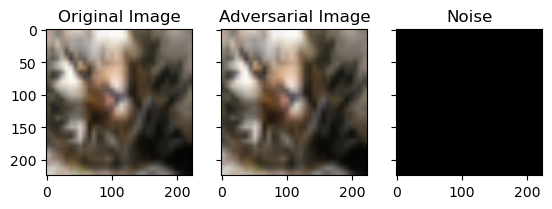

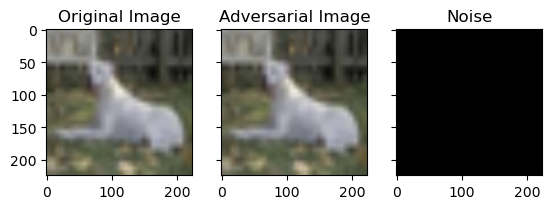

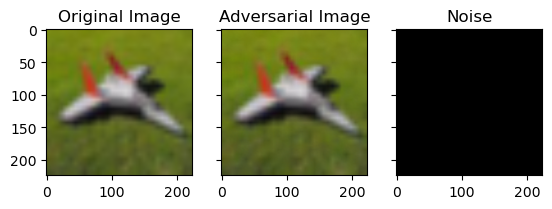

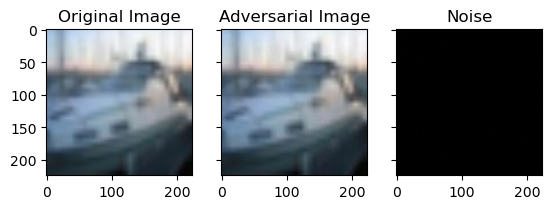

In [16]:
for eps in epsilons:

    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = fgsm_attack(classifier, imgs, labels, eps, dataset)

        img, adv_img = imgs[0], adv_imgs[0]
        img, adv_img = img.cpu(), adv_img.cpu()
        img, adv_img = img.squeeze(), adv_img.squeeze()
        unnormalize_transform = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=[1. / 0.5, 1. / 0.5, 1. / 0.5]),
                                        transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1, 1, 1])])
        img, adv_img = unnormalize_transform(img), unnormalize_transform(adv_img)
        img, adv_img = img.permute(1, 2, 0).detach().numpy(), adv_img.permute(1, 2, 0).detach().numpy() 
        # arr = arr.cpu()
        # img, adv_img = to_numpy_array_cifar10(img), to_numpy_array_cifar10(adv_img)
        noise = adv_img - img
        
        
        plot_name = f"./plots/fgsm_attack_cifar10_epsilon_{eps}.png"
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        ax1.imshow(img)
        ax1.set_title("Original Image")
        ax2.imshow(adv_img)
        ax2.set_title("Adversarial Image")
        ax3.imshow(noise)
        ax3.set_title("Noise")
        f.savefig(plot_name, transparent=False, dpi=300)
        break